In [39]:
import pandas as pd
import numpy as np
import os
#import what is needed for pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import learning_curve

### Dataset manipulation

In [40]:
mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')
#filter by column Hugo_symbol == 'TP53'
mutations = mutations[mutations['HugoSymbol'] == 'TP53']

C:\Users\tommy\AppData\Local\Temp\ipykernel_22676\3768806862.py:1: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')


In [41]:
model = pd.read_csv('data/Model.csv')
expression = pd.read_csv('data/OmicsExpressionProteinCodingGenesTPMLogp1.csv')

In [42]:
#rename the first column of expression to 'ModelID'
expression.rename(columns={expression.columns[0]: 'ModelID'}, inplace=True)

In [43]:
merged = pd.merge(expression, mutations[['ModelID', 'HugoSymbol']], on='ModelID', how='left')

In [44]:
# create a boolean column 'Mutated' which is 1 if 'HugoSymbol' is not null and 0 if it is null
merged['Mutated'] = np.where(merged['HugoSymbol'].isnull(), 0, 1) 

In [45]:
#count number of mutated and non mutated samples
merged['Mutated'].value_counts()

Mutated
1    1108
0     687
Name: count, dtype: int64

### PCA Analysis v1 (scale before)

In [46]:
#run pca on the merged dataframe
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca = PCA(n_components=128)
#drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
pca_input = merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
#standardize the data
scaler = StandardScaler()
pca_input = scaler.fit_transform(pca_input)
#fit the pca model
pca.fit(pca_input)
#transform the data
pca_result = pca.transform(pca_input)
#convert to dataframe
pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
#add the column 'Mutated' to the pca_result dataframe
pca_result['Mutated'] = merged['Mutated'].values
#add the column 'ModelID' to the pca_result 
pca_result['ModelID'] = merged['ModelID'].values

### PCA Analysis v2 (scale after)

In [47]:
# #run pca on the merged dataframe
# #drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
# pca = PCA(n_components=128)
# #drop the columns 'ModelID', 'HugoSymbol', 'Mutated'
# pca_input = merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
# #fit the pca model
# pca.fit(pca_input)
# #transform the data
# pca_result = pca.transform(pca_input)
# #standardize the data
# scaler = StandardScaler()
# pca_result = scaler.fit_transform(pca_result)
# #convert to dataframe
# pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# #add the column 'Mutated' to the pca_result dataframe
# pca_result['Mutated'] = merged['Mutated'].values
# #add the column 'ModelID' to the pca_result 
# pca_result['ModelID'] = merged['ModelID'].values

### Data for modelling

In [48]:
#split the data into train and test sets
X = pca_result.drop(columns=['Mutated', 'ModelID'])
y = pca_result['Mutated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Cross Validation

In [49]:
# Setup stratified k-fold cross validation (preserves class distribution)
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print(f"{name} - Mean ROC AUC: {scores.mean():.4f} (±{scores.std():.4f})")

Logistic Regression - Mean ROC AUC: 0.8916 (±0.0248)
Random Forest - Mean ROC AUC: 0.8654 (±0.0154)


### Model 1: Logistic Regression

In [50]:
#fit the model
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# show the table
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)
print("ROC AUC Score:")
print(roc_auc)

Confusion Matrix:
[[104  34]
 [ 29 192]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       138
           1       0.85      0.87      0.86       221

    accuracy                           0.82       359
   macro avg       0.82      0.81      0.81       359
weighted avg       0.82      0.82      0.82       359

ROC AUC Score:
0.8812709030100334


In [59]:
#fit the model
lg_model = LogisticRegression(max_iter=1000, solver='saga', penalty='l1', class_weight=None, C=0.1)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# show the table
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)
print("ROC AUC Score:")
print(roc_auc)

Confusion Matrix:
[[105  33]
 [ 30 191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       138
           1       0.85      0.86      0.86       221

    accuracy                           0.82       359
   macro avg       0.82      0.81      0.81       359
weighted avg       0.82      0.82      0.82       359

ROC AUC Score:
0.8853695324283559


c:\Users\tommy\anaconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Model 2: Random Forest

In [51]:
#fit the model
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_depth=10, class_weight='balanced')
rf_model.fit(X_train, y_train)
#predict the test set
y_pred = rf_model.predict(X_test)
#predict the probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# show the table
print("Confusion Matrix:")
print(cm)
print(report)
print("ROC AUC Score:")
print(roc_auc)


Confusion Matrix:
[[ 79  59]
 [ 18 203]]
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       138
           1       0.77      0.92      0.84       221

    accuracy                           0.79       359
   macro avg       0.79      0.75      0.76       359
weighted avg       0.79      0.79      0.78       359

ROC AUC Score:
0.8810085907272608


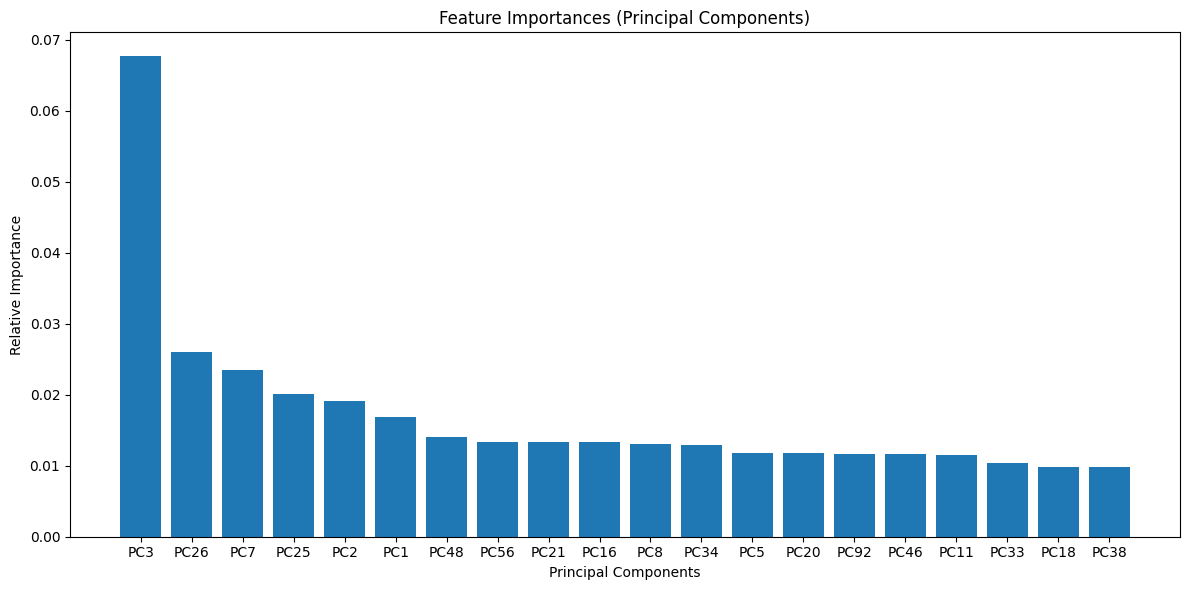

In [52]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances (top 20)
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (Principal Components)')
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), [f'PC{i+1}' for i in indices[:20]])
plt.xlabel('Principal Components')
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.show()

### Extra

In [53]:
# def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     plt.figure(figsize=(10, 6))
#     plt.title("Learning Curve")
#     plt.xlabel("Training examples")
#     plt.ylabel("ROC AUC Score")
#     plt.grid()
    
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
#     plt.legend(loc="best")
#     return plt

# # Create a pipeline with your model
# model = RandomForestClassifier(n_estimators=100)

# # Plot learning curve
# plot_learning_curve(model, X, y, 
#                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
# plt.show()

In [54]:
# from sklearn.manifold import TSNE

# # Get 128 principal components after scaling
# pca = PCA(n_components=128)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated']))
# X_pca = pca.fit_transform(X_scaled)

# # Create DataFrame for visualization
# pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
# pca_df['Mutated'] = merged['Mutated'].values

# # Use t-SNE to reduce to 2D for visualization
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(pca_df.drop(columns=['Mutated']))

# # Create DataFrame for t-SNE visualization
# tsne_df = pd.DataFrame({
#     'TSNE1': X_tsne[:, 0],
#     'TSNE2': X_tsne[:, 1],
#     'Mutated': pca_df['Mutated']
# })

# # Plot
# plt.figure(figsize=(10, 8))
# sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Mutated', palette='viridis', alpha=0.8)
# plt.title('t-SNE Visualization of TP53 Mutation Status (128 Components)')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend(title='TP53 Mutated')
# plt.show()

In [55]:
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.under_sampling import RandomUnderSampler

# # Using SMOTE for the binary classification
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# print(f"Original class distribution: {pd.Series(y).value_counts().to_dict()}")
# print(f"Resampled class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")

# # Or create an imbalanced pipeline
# imb_pipeline = ImbPipeline([
#     ('scaler', StandardScaler()),
#     ('pca', PCA(n_components=128)),
#     ('sampling', SMOTE(random_state=42)),
#     ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# # Cross-validation with the imbalanced pipeline
# cv_scores = cross_val_score(imb_pipeline, 
#                           merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated']),
#                           merged['Mutated'], 
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                           scoring='roc_auc')
# print(f"SMOTE Pipeline ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

In [ ]:


# # Reduced parameter grid for Random Forest
# param_dist_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'class_weight': [None, 'balanced']
# }

# # For Logistic Regression - much smaller grid
# param_dist_lr = {
#     'C': [0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],  # These solvers support both L1 and L2
#     'class_weight': [None, 'balanced']
# }

# # Configure RandomizedSearchCV - limit to 20 iterations
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_distributions=param_dist_rf,
#     n_iter=20,  # Try only 20 combinations
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Reduce to 3 folds
#     scoring='roc_auc',
#     n_jobs=-1,
#     random_state=42,
#     verbose=1  # Show progress
# )

# # Fit the model
# random_search.fit(X, y)
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best ROC AUC: {random_search.best_score_:.4f}")

# # Use the best model
# best_rf = random_search.best_estimator_

In [58]:
from sklearn.model_selection import RandomizedSearchCV
# perform hyperparameter tuning using RandomizedSearchCV for logistic regression
param_dist_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # These solvers support both L1 and L2
    'class_weight': [None, 'balanced']
}
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_distributions=param_dist_lr,
    n_iter=20,  # Try only 20 combinations
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Reduce to 3 folds
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1  # Show progress
)

# Fit the model
random_search_lr.fit(X, y)
print(f"Best parameters for Logistic Regression: {random_search_lr.best_params_}")
print(f"Best ROC AUC for Logistic Regression: {random_search_lr.best_score_:.4f}")
# Use the best model
best_lr = random_search_lr.best_estimator_
#predict the test set



Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\tommy\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Logistic Regression: {'solver': 'saga', 'penalty': 'l1', 'class_weight': None, 'C': 0.1}
Best ROC AUC for Logistic Regression: 0.8803


c:\Users\tommy\anaconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'solver': 'saga', 'penalty': 'l1', 'class_weight': None, 'C': 0.1}

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10, 'class_weight': 'balanced'}
Best ROC AUC: 0.8701